<div style = 'text-align: center;'>
    <img src = '../images/ga_logo_large.png'>
</div>

---
## **Capstone Project: Ride BigApple** 🚖🍎

------
#### **Exploratory Data Analysis**

In [8]:
# import personal library
import importlib.util
import sys

path_to_library = '../scripts/personal_library.py'

# load module
spec = importlib.util.spec_from_file_location('personal_library', path_to_library)
lu = importlib.util.module_from_spec(spec)
sys.modules['personal_library'] = lu
spec.loader.exec_module(lu)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# maps module
#import googlemaps

# import geodesic module
from geopy.distance import geodesic

In [11]:
# read in file
file_path = '../data/clean_data/taxi_clean_set_v1.csv'

taxi = pd.read_csv(file_path, index_col = 'key')
print(taxi.shape)
taxi.head(1)

(53353, 12)


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute,geodesic_distance
key,,,,,,,,,,,,
2009-01-01 00:48:11.000000200,11.0,-73.993578,40.721298,-73.967109,40.756657,4,2009,January,Thursday,0,48,4.518465


In [16]:
taxi.tail(2)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute,geodesic_distance
key,,,,,,,,,,,,
2014-12-31 21:56:56.000000400,10.0,-73.983126,40.773427,-73.956101,40.773936,1,2014,December,Wednesday,21,56,2.282213
2014-12-31 22:04:00.000000175,7.0,-73.975483,40.757470,-73.981932,40.775267,1,2014,December,Wednesday,22,4,2.049981


----
**Categorical Data Types**<br>
Convert columns `month` and `day_of_week` to categorical data types.

In [19]:
# list items in correct sequence
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [21]:
# data conversion to follow correct sequence
taxi['day_of_week'] = pd.Categorical(taxi['day_of_week'], categories = day_order, ordered = True)
taxi['month'] = pd.Categorical(taxi['month'], categories = month_order, ordered = True)

In [23]:
# confirm
taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53353 entries, 2009-01-01 00:48:11.000000200 to 2014-12-31 22:04:00.000000175
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   fare_amount        53353 non-null  float64 
 1   pickup_longitude   53353 non-null  float64 
 2   pickup_latitude    53353 non-null  float64 
 3   dropoff_longitude  53353 non-null  float64 
 4   dropoff_latitude   53353 non-null  float64 
 5   passenger_count    53353 non-null  int64   
 6   year               53353 non-null  int64   
 7   month              53353 non-null  category
 8   day_of_week        53353 non-null  category
 9   hour               53353 non-null  int64   
 10  minute             53353 non-null  int64   
 11  geodesic_distance  53353 non-null  float64 
dtypes: category(2), float64(6), int64(4)
memory usage: 4.6+ MB


-----
**Correlations**<br>
The aim is to be able to accurately predict a taxi fare once a passenger enters a pickup and dropoff location.  So, based on that premise, let's start by taking a look at all possible correlations between `fare_amount` and other columns.

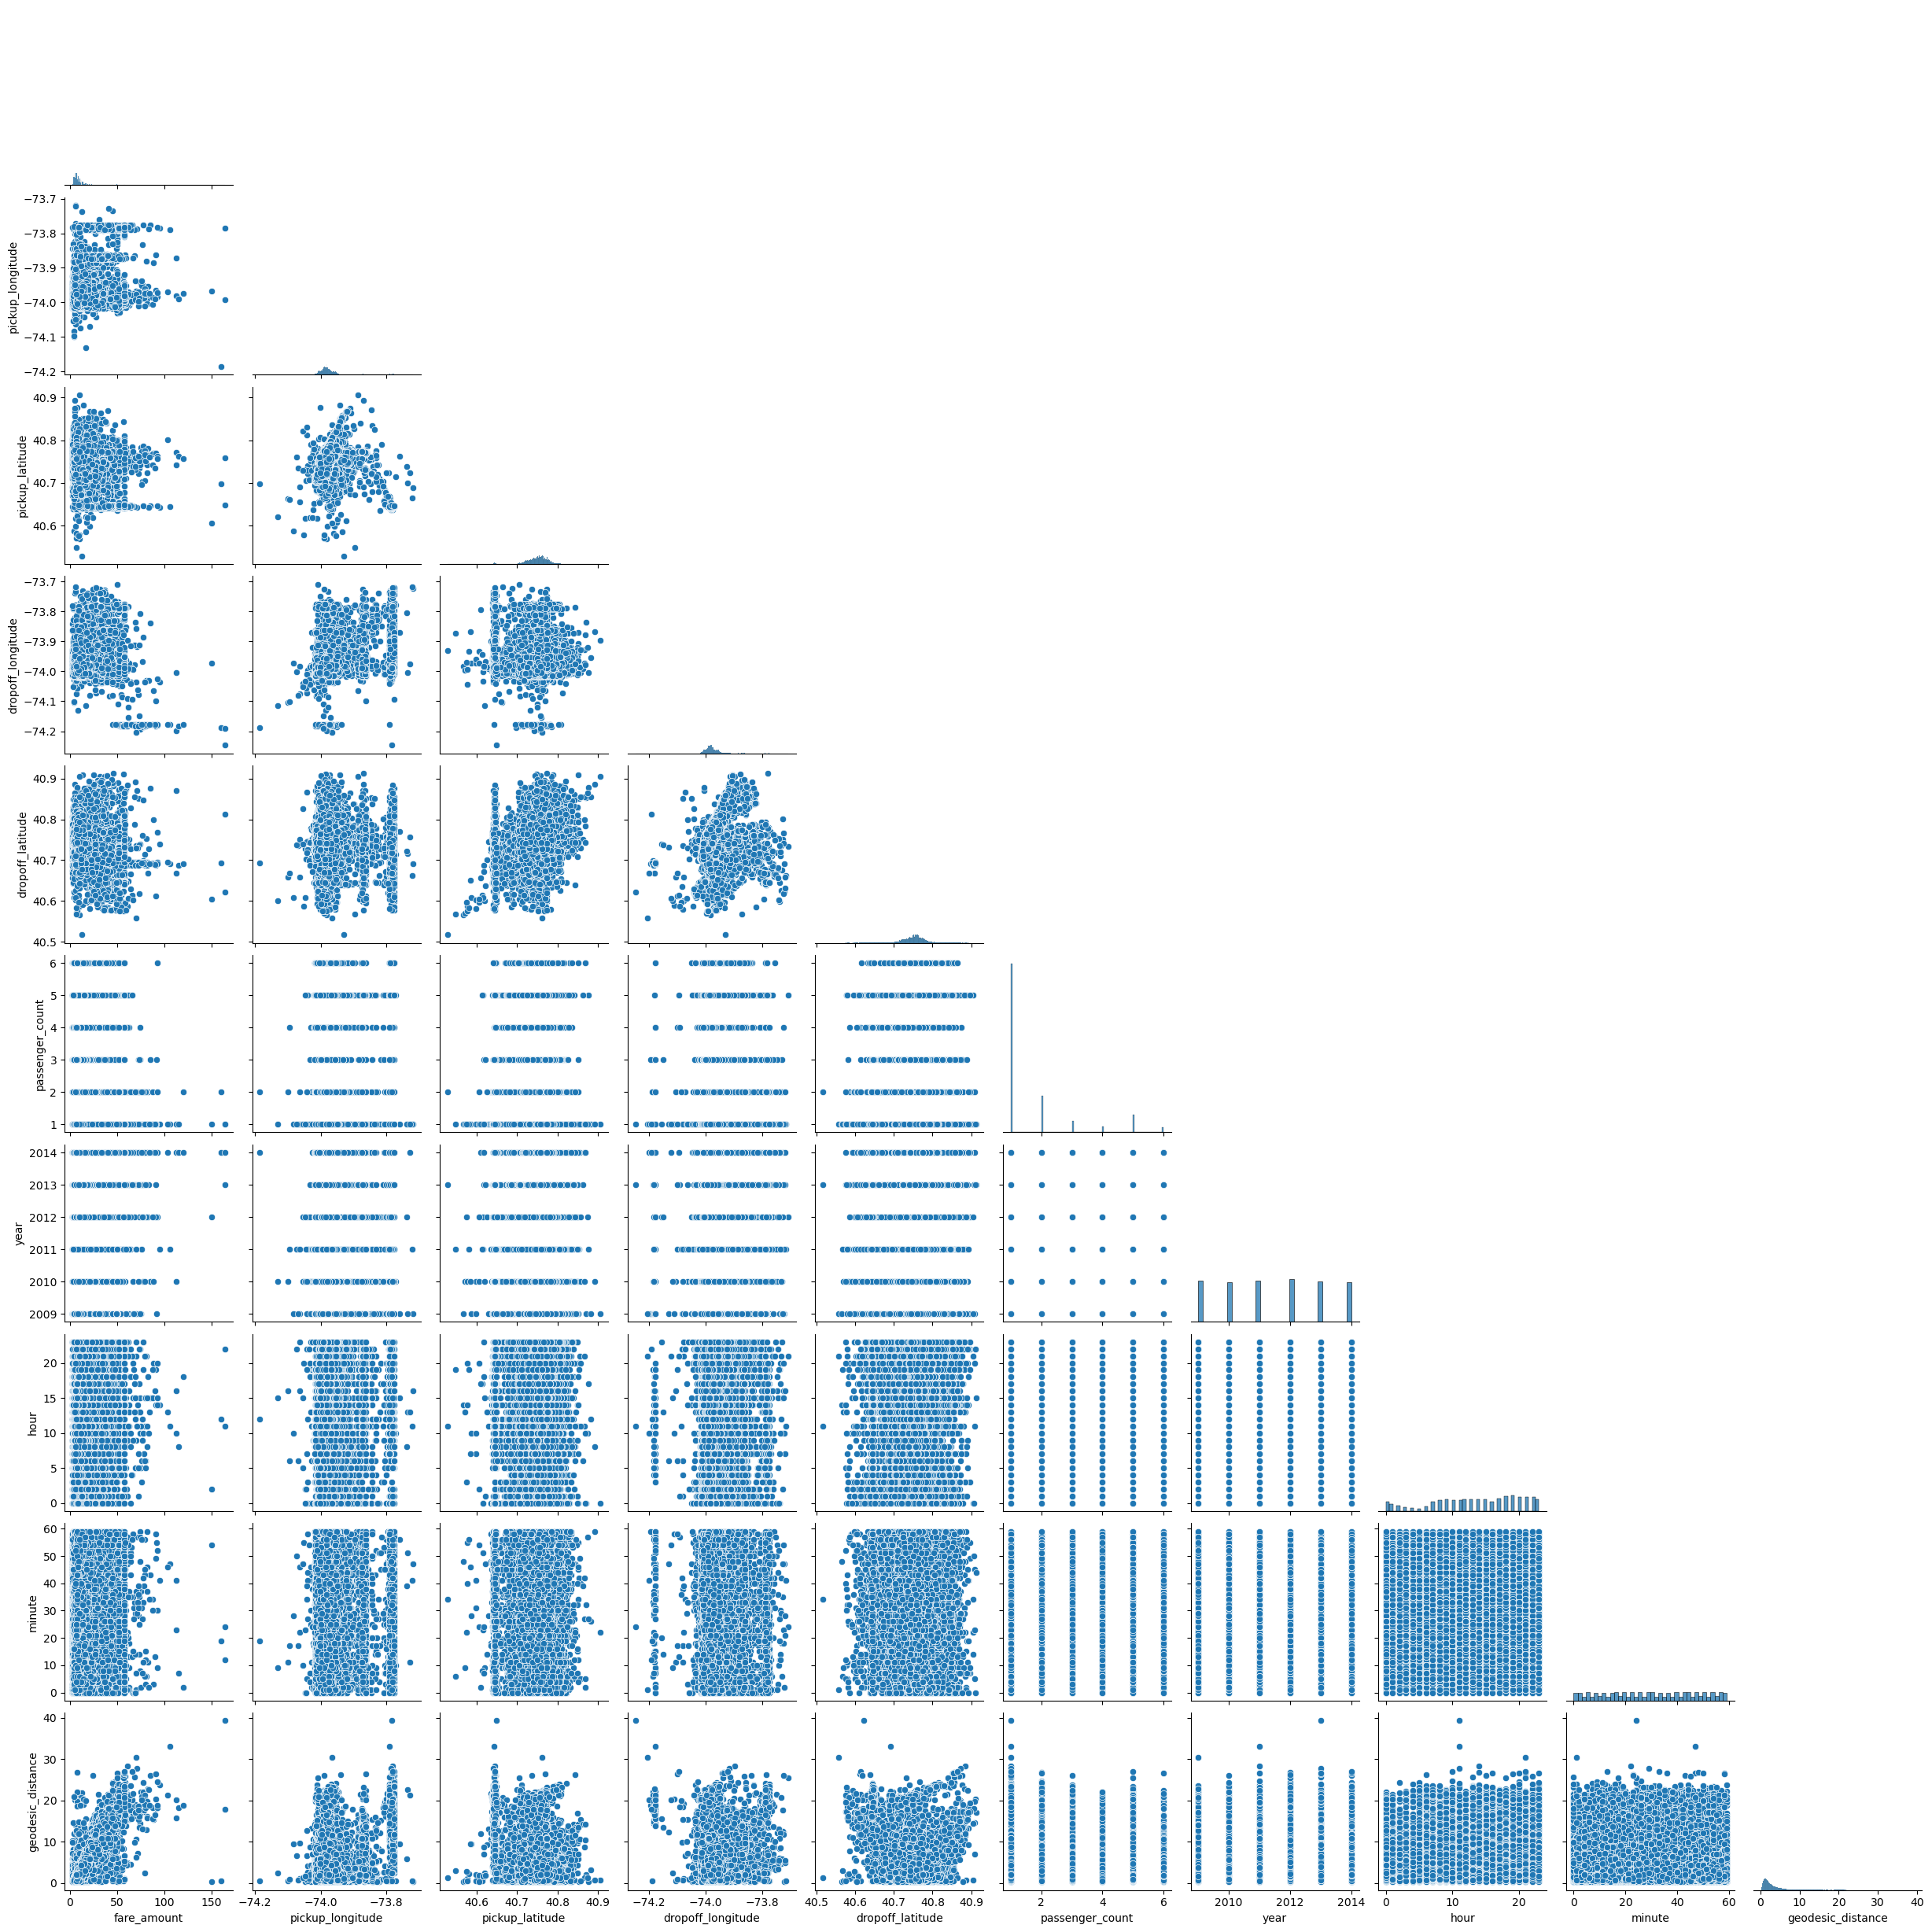

In [15]:
sns.pairplot(taxi, corner = True)
plt.savefig('../images/pairplot.png');

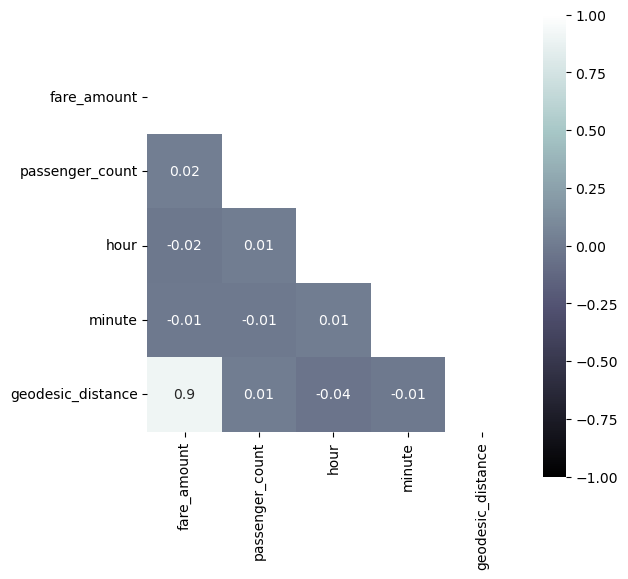

In [25]:
columns = ['fare_amount', 'passenger_count', 'hour', 'minute', 'geodesic_distance']
lu.plot_heatmap(taxi, columns)
plt.savefig('../images/heatmap1.png')

The strongest predictor of fare, not surprinsingly, is distance, which shows a very strong correlation factor of 0.9.<br>
Distance is derived from the pickup and dropoff coordinates. Out of curiosity, let's see how the actual coordinates correlate with the fare amount.

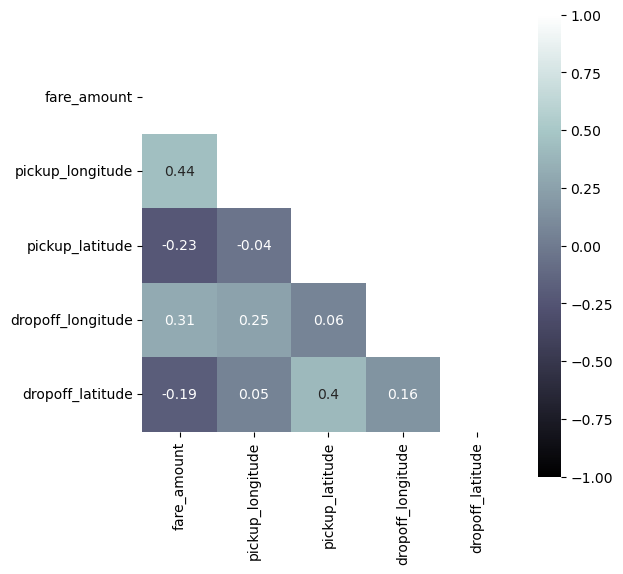

In [18]:
columns = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
lu.plot_heatmap(taxi, columns)
plt.savefig('../images/heatmap2.png')

The strongest correlations are between fare amount and the longitude parameters, that's east-west travel.  Since 90% of pickups occur in Manhattan, it kind of makes a bit of sense. Traffic lights in Manhattan are sincronized to favor continous traffic flow along the avenues (north-south) travel, and they're also much wider, so speeds are higher.  Traffic along the numbered streets (east-west travel) is always slower, the streets are narrower, and many serve as on/off loading zones for the buildings, so all those factors slow down speeds.  Therefore, since a portion of the fare is 50 cents for every minute in stopped or slow traffic, perhaps this is having a bit of an impact on the final fare.

---
**Fare amount by passenger count**

In [29]:
# group by passenger
result = taxi.groupby('passenger_count')['fare_amount'].agg(
    count = 'count',
    avg_fare = 'mean',
)
# add percent count 
result['pct_count'] = (result['count'] / result['count'].sum())*100
# display result
result

,count,avg_fare,pct_count
passenger_count,,,
1,36904,10.966326,69.169494
2,7950,11.883130,14.900755
3,2448,11.134988,4.588308
4,1194,11.507848,2.237925
5,3792,11.118892,7.107379
6,1065,12.377042,1.996139


Although the heatmap showed a very weak correlation between these two columns, the average fare is 12.86% higher with six passengers relative to 1 passenger.  The number of rides with six passengers, however, is very low, about 2% compared to all rides. If this feature is used in the final model, these percents might guide the weights for fine-tuning.

---
**Distance by passenger count**

In [24]:
taxi.groupby('passenger_count')['geodesic_distance'].agg(
    avg_distance = 'mean',
    median_distance = 'median',
    maximum_distance = 'max'
)

,avg_distance,median_distance,maximum_distance
passenger_count,,,
1,3.312971,2.166829,39.277375
2,3.595272,2.296798,26.788182
3,3.320635,2.205420,26.091788
4,3.410620,2.264793,22.119030
5,3.387749,2.163924,26.923122
6,3.541830,2.328739,26.700662


There are no apparent relationships between the number of passengers and distances traveled.

----
**Fare amount by year**

In [27]:
taxi.groupby('year')['fare_amount'].mean()

year
2009    10.139742
2010    10.149604
2011    10.367849
2012    11.052419
2013    12.466668
2014    12.835195
Name: fare_amount, dtype: float64

Average fares increased each subsequent year, but the increases are very gradual, nothing dramatic that would warrant further exploration.

----
**Fare amount and distance by hour**

In [46]:
result = taxi.groupby('hour').agg(
    avg_fare = ('fare_amount', 'mean'),
    ride_count = ('fare_amount', 'count'),
    avg_distance = ('geodesic_distance', 'mean')
)
result.sort_values(by = 'ride_count', ascending = False)

,avg_fare,ride_count,avg_distance
hour,,,
19,10.322926,3404,3.052378
18,10.669078,3286,3.042145
20,10.781098,3169,3.394169
21,10.654237,3028,3.373492
22,11.142377,3008,3.601389
17,11.172552,2719,3.203815
12,10.920287,2612,2.936203
23,11.344538,2607,3.697986
14,11.828676,2598,3.317024


Most rides occur in the evening, between 6pm and 10pm. This coincides with people leaving work and going home or to social activities. Interestingly, the highest average fares occur instead early in the morning, from 4am to 6am.  At the same time, there are fewer rides during this time frame, but average distances are longer too.  Based on these findings, the `hour` column is a feature of high interest for the predictive model.<br><br>
Let's visualize the number or rides and average fares per hour.

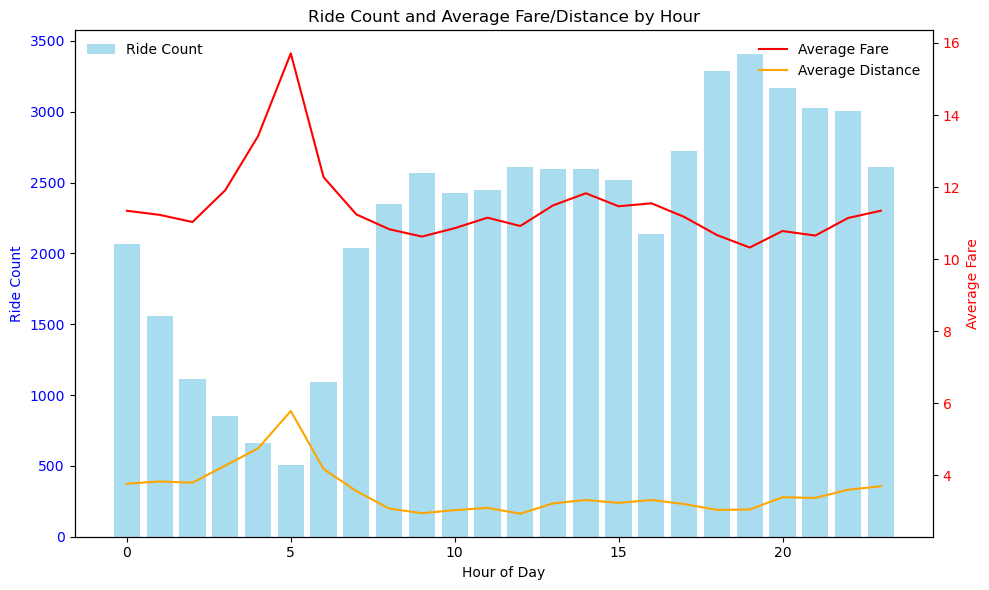

In [59]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the ride counts as vertical bars on the primary y-axis
ax1.bar(result.index, result['ride_count'], color='skyblue', alpha=0.7, label='Ride Count')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Ride Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the average fare
ax2 = ax1.twinx()
ax2.plot(result.index, result['avg_fare'], color='red', label='Average Fare')
ax2.plot(result.index, result['avg_distance'], color='orange', label='Average Distance')
ax2.set_ylabel('Average Fare', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legends
plt.title('Ride Count and Average Fare/Distance by Hour')
fig.tight_layout()
ax1.legend(frameon = False, loc='upper left')
ax2.legend(frameon = False, loc='upper right');



This is an insightful interaction.  As the number of rides per hour decrease during the overnight hours, the average traveled distance and average fare increase peaking at the time slot from 5am to 6am. Then rides increase dramatically and fares plus distance estabilize.  Consider an iteraction feature (`geodesic_distance` x `hour`) for the predictive model.

---
**Fare amount and distance by day of the week**

In [35]:
result = taxi.groupby('day_of_week', observed = False).agg(
    avg_fare = ('fare_amount', 'mean'),
    ride_count = ('fare_amount', 'count'),
    avg_distance = ('geodesic_distance', 'mean')
)
result.sort_index()

,avg_fare,ride_count,avg_distance
day_of_week,,,
Monday,11.149768,6816,3.390814
Tuesday,11.040859,7556,3.270575
Wednesday,11.092342,7689,3.251785
Thursday,11.491960,7950,3.398121
Friday,11.350768,8280,3.384521
Saturday,10.710009,8086,3.277820
Sunday,11.304223,6976,3.625764


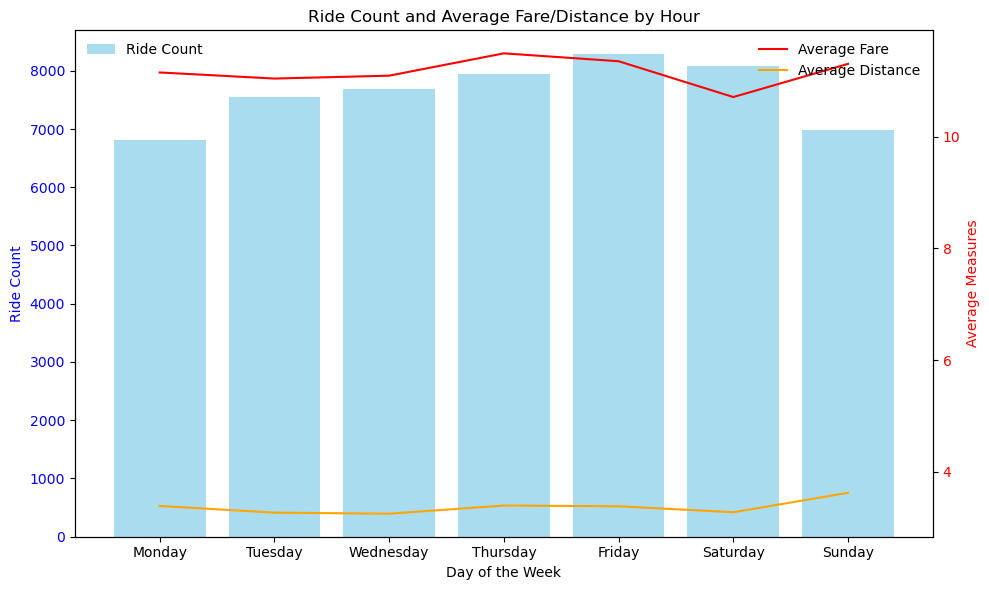

In [36]:
fig, ax1 = plt.subplots(figsize = (10, 6))

# Plot the ride counts as vertical bars on the primary y-axis
ax1.bar(result.index, result['ride_count'], color='skyblue', alpha=0.7, label='Ride Count')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Ride Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the average fare
ax2 = ax1.twinx()
ax2.plot(result.index, result['avg_fare'], color='red', label='Average Fare')
ax2.plot(result.index, result['avg_distance'], color='orange', label='Average Distance')
ax2.set_ylabel('Average Measures', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legends
plt.title('Ride Count and Average Fare/Distance by Hour')
fig.tight_layout()
ax1.legend(frameon = False, loc='upper left')
ax2.legend(frameon = False, loc='upper right');

The number of rides peaks on Fridays, but the average fare peaks on Thursday.  However, Friday commands the second highest average fares.  Then rides drop over the weekend. In order to capture weekend dynamics in the dataset, a new column should be created (`weekend`) with two possible values, 1 for yes, it is a weekend ride, and 0 for all other rides.  Define weekend as from Friday at noon until Sunday at 11:59pm.

---
**Fare amount and distance by month**

In [39]:
result = taxi.groupby('month', observed = False).agg(
    avg_fare = ('fare_amount', 'mean'),
    ride_count = ('fare_amount', 'count'),
    avg_distance = ('geodesic_distance', 'mean')
)
result.sort_values(by = 'avg_fare', ascending = False)

,avg_fare,ride_count,avg_distance
month,,,
November,11.642971,4396,3.430619
December,11.604102,4327,3.392582
September,11.598188,4288,3.401776
May,11.373013,4680,3.508677
August,11.307053,4174,3.534186
October,11.295218,4548,3.304305
June,11.191199,4546,3.367696
April,10.986104,4600,3.349829
July,10.917454,4439,3.364953


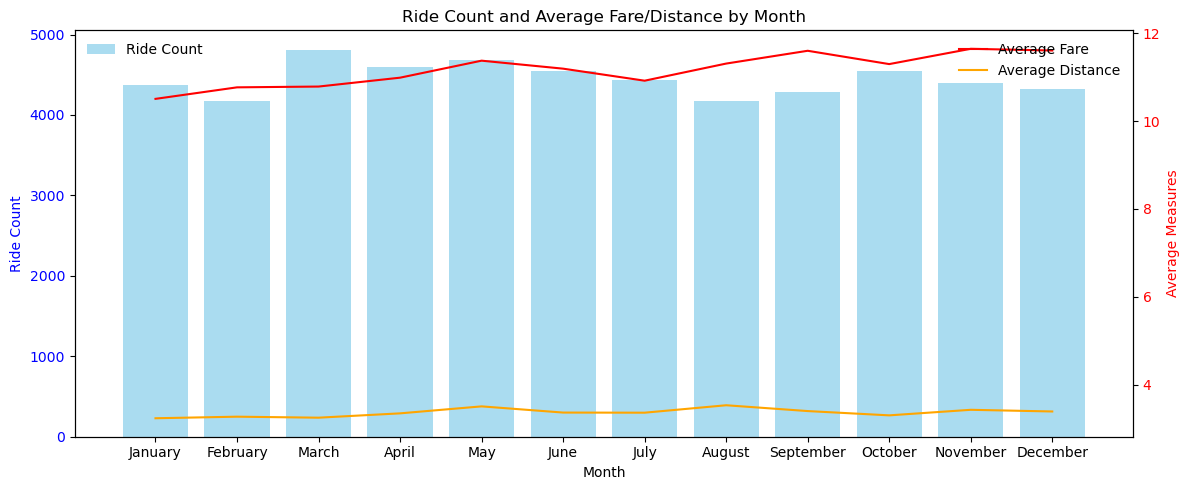

In [40]:
fig, ax1 = plt.subplots(figsize = (12, 5))

# Plot the ride counts as vertical bars on the primary y-axis
ax1.bar(result.index, result['ride_count'], color='skyblue', alpha=0.7, label='Ride Count')
ax1.set_xlabel('Month')
ax1.set_ylabel('Ride Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for the average fare
ax2 = ax1.twinx()
ax2.plot(result.index, result['avg_fare'], color='red', label='Average Fare')
ax2.plot(result.index, result['avg_distance'], color='orange', label='Average Distance')
ax2.set_ylabel('Average Measures', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title and legends
plt.title('Ride Count and Average Fare/Distance by Month')
fig.tight_layout()
ax1.legend(frameon = False, loc='upper left')
ax2.legend(frameon = False, loc='upper right');

Most rides tend to occur in the spring (March thru May), while the least rides occur in months that are opposite in weather: February, which is the coldest month; and August, which is the hottest month.  The average distance traveled seems to hold steady throughout the year, while the average fare seems to steadily increase after dipping in the summer, with Fall commanding the the highest fares. November and December in particular have the highest fares, this coincides with the holiday season and the flock of tourists that descend on the city for the festivities.  Another possible column that may highlight these patterns would be `xmas`, where rides in November and December would get a value of 1, and the remaining months would get a value of 0.

----
**Fare amount vs. Distance**

The heatmap at the start of this notebook indicated a very strong correlation between `fare_amount` and `geodesic_distance`. It's time to delve into this specific relationship. So, let's start with a scatter plot to better visualize the relationship.

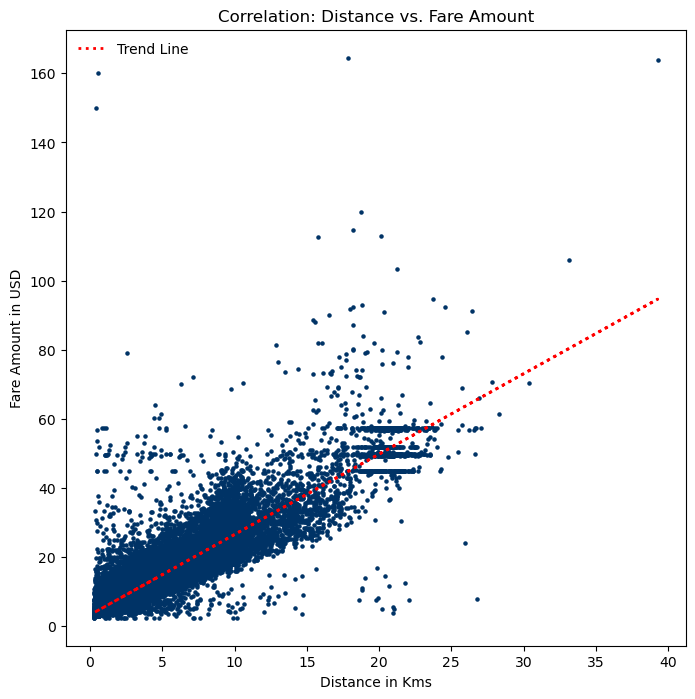

In [44]:
# box
plt.figure(figsize = (8, 8))
# scatter plot
plt.scatter(taxi['geodesic_distance'], taxi['fare_amount'], s = 5, color = '#003366')

# trend line
x = taxi['geodesic_distance']
y = taxi['fare_amount']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# trend line plot
plt.plot(x, trendline(x), color='#ff0000', linewidth=2, linestyle = ':', label='Trend Line')

plt.title('Correlation: Distance vs. Fare Amount')
plt.xlabel('Distance in Kms')
plt.ylabel('Fare Amount in USD')
plt.legend(frameon = False);

The positive correlation is clearly visible and it makes sense.  A big portion of the final fare is dictated by traveled distance.  There are, however, a couple of outliers I'd like to discard, the two rides with distances under 5 kms and fares above 140 dollars.

In [46]:
mask = (taxi['fare_amount'] > 140) & (taxi['geodesic_distance'] < 5)
taxi[mask].head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,minute,geodesic_distance
key,,,,,,,,,,,,
2012-08-04 02:54:58.000000200,150.0,-73.966553,40.605820,-73.971368,40.604355,1,2012,August,Saturday,2,54,0.438791
2014-04-24 12:19:35.000000300,160.0,-74.185481,40.698439,-74.187104,40.693440,2,2014,April,Thursday,12,19,0.571827


In [47]:
# grab the keys
keys = ['2012-08-04 02:54:58.000000200', '2014-04-24 12:19:35.000000300']

In [48]:
# drop two outliers
print(f'Before: {taxi.shape}')
taxi.drop(index = keys, inplace = True)
print(f'After: {taxi.shape}')

Before: (53353, 12)
After: (53351, 12)


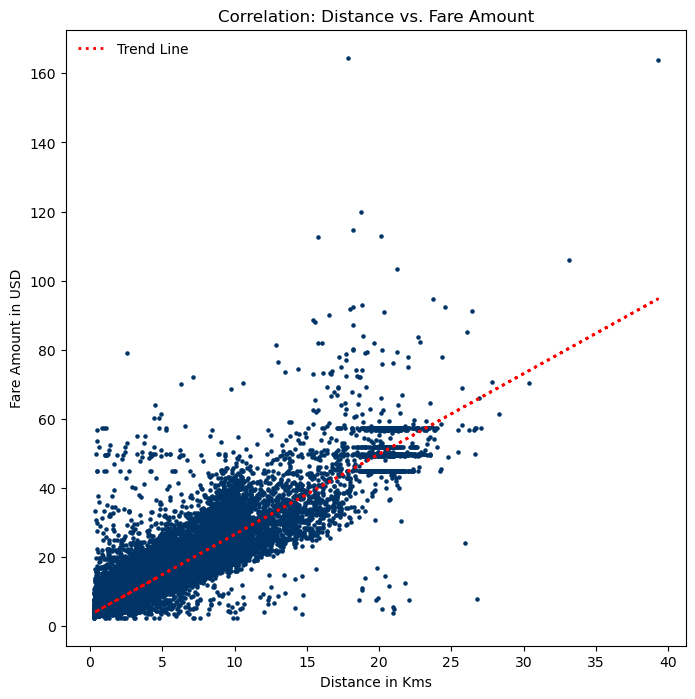

In [82]:
# plot again
# box
plt.figure(figsize = (8, 8))
# scatter plot
plt.scatter(taxi['geodesic_distance'], taxi['fare_amount'], s = 5, color = '#003366')

# trend line
x = taxi['geodesic_distance']
y = taxi['fare_amount']
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# trend line plot
plt.plot(x, trendline(x), color='#ff0000', linewidth=2, linestyle = ':', label='Trend Line')

plt.title('Correlation: Distance vs. Fare Amount')
plt.xlabel('Distance in Kms')
plt.ylabel('Fare Amount in USD')
plt.legend(frameon = False);
plt.savefig('../images/scatterplot_distance_fare.png')

Let's now take a look at the distributions for both columns.

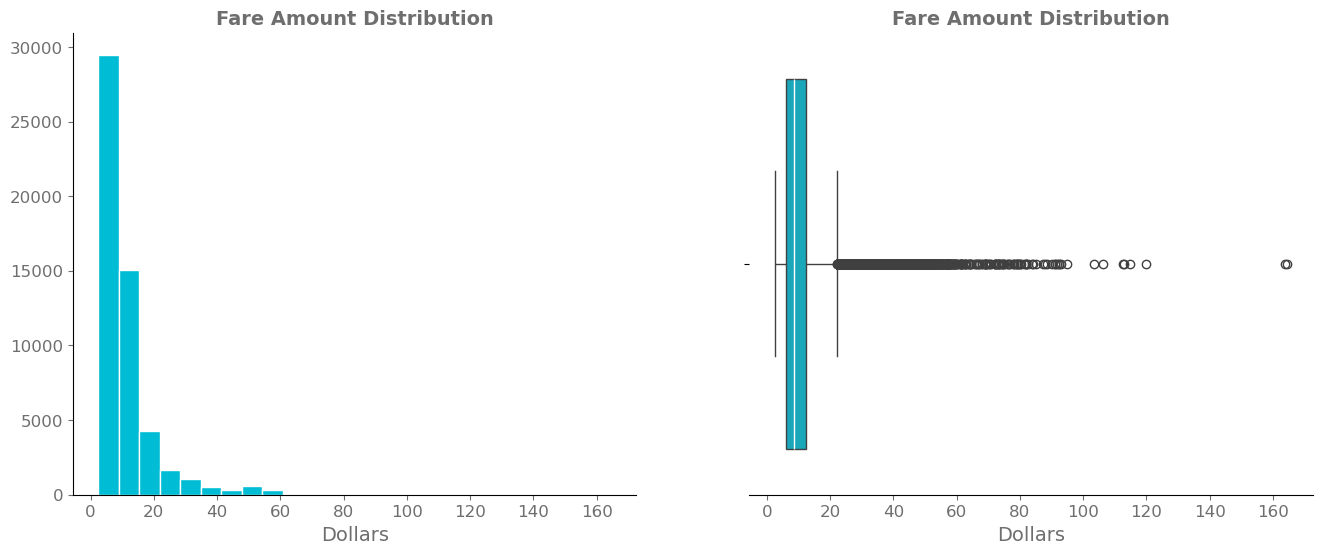

In [94]:
lu.plot_hist_box(taxi, 'fare_amount', 'Fare Amount Distribution', 'Dollars')
plt.savefig('../images/hist_boxplot_fare_amount.png')

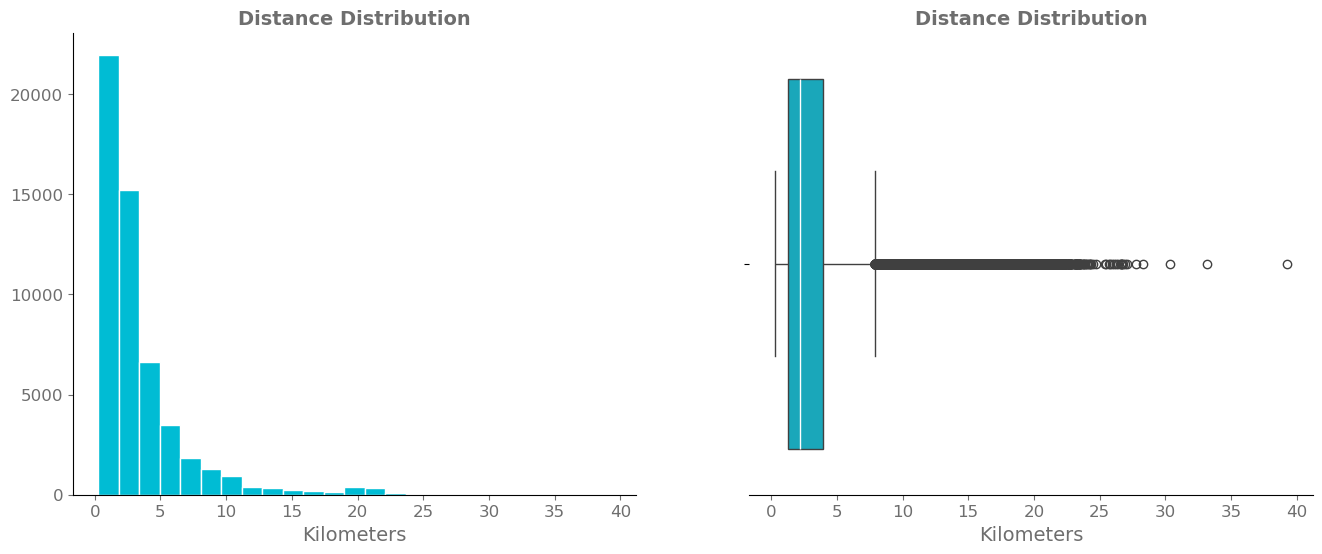

In [97]:
lu.plot_hist_box(taxi, 'geodesic_distance', 'Distance Distribution', 'Kilometers')
plt.savefig('../images/hist_boxplot_distance.png')

Both variables show right-skewed distributions.  This is important to know when building the model, specially for the target variable. Perhaps a log transformation may improve performance, if needed.<br><br>
This is the end of EDA phase.  This dataset is ready for modeling based on the current analysis.  Save a clean copy since two rows were dropped.

In [90]:
taxi.to_csv('../data/clean_data/taxi_clean_set_v2.csv')